In [2]:
from transformer_model import EncoderOnlyTransformerModel
from dataloader import QCTempDataset, DataLoader
import numpy as np
import torch

load = True
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp",
                        size=(4,4), Rb_per_a=1.2, delta_per_omega=1.1, lattice='SquareLattice', query_beta=lambda x: 0< x < 1)  
dl = DataLoader(dataset, batchsize=100, epochs=20, nbatches=10_000, dataset_index=None)
if load:
    transformer = EncoderOnlyTransformerModel.load("/home/jkambulo/projects/def-rgmelko/jkambulo/code/qc-temp/transformer/checkpoints/model_trained3.pt")
else:
    transformer = EncoderOnlyTransformerModel(atom_grid_shape=(4,4), spin_states=2, 
                                    embedding_size=4, nhead=4,
                                    dim_feedforward=2048, nlayers=5,dropout=0, n_phys_params=1)
# transformer.start_training(dl,checkpoint_path = './checkpoints/model_moreparams.pt', data_file = './checkpoints/data_moreparams.csv', log_interval=100)

In [2]:
sum(p.numel() for p in transformer.parameters())


36175

In [3]:
{1,2,3} & {2,3,4}

{2, 3}

In [14]:
import psutil
psutil.virtual_memory()

svmem(total=134783528960, available=60258820096, percent=55.3, used=57206939648, free=4383371264, active=74130350080, inactive=38517624832, buffers=53399552, cached=73139818496, shared=16763404288, slab=13912907776)

In [5]:
transformer.eval()
batchsize = 1000
experiments = 16
prob = np.zeros((29,experiments))
j = 14    
tmp = dataset.datasets[j][:]
for k in range(experiments):
    np.random.shuffle(tmp)
    data = torch.from_numpy(tmp[:,:batchsize]).type(torch.int64)
    for i in range(0,29):
        output = transformer(data, phys_params=torch.tensor([[dataset.beta[i]]*batchsize]))
        output *= torch.nn.functional.one_hot(data, num_classes=2)
        prob[i,k] = torch.sum(output).item()
    


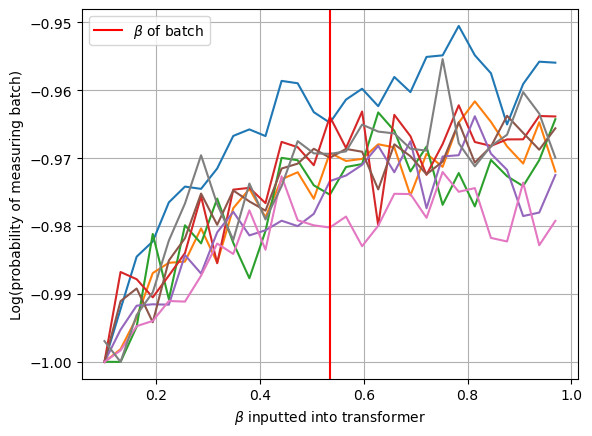

In [33]:
import matplotlib.pyplot as plt

# plt.plot(dataset.beta, prob)
# plt.plot(dataset.beta, -prob/np.min(prob, axis=0)[None])
# # plt.plot(dataset.beta, np.mean(prob,axis=1), label='Average probability over multiple batches')
# plt.axvline(x=dataset.beta[j],c='r',label=r'$\beta$ of batch')
# plt.xlabel(r"$\beta$ inputted into transformer")
# plt.ylabel("Log(probability of measuring batch)")
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(dataset.beta, prob)
plt.plot(dataset.beta, -prob2/np.min(prob2, axis=0)[None])
# plt.plot(dataset.beta, np.mean(prob,axis=1), label='Average probability over multiple batches')
plt.axvline(x=dataset.beta[j],c='r',label=r'$\beta$ of batch')
plt.xlabel(r"$\beta$ inputted into transformer")
plt.ylabel("Log(probability of measuring batch)")
plt.legend()
plt.grid()
plt.show()

In [2]:
def compute_histograms(dataset: QCTempDataset, dataset_slice=slice(None), filter_data=slice(None), atoms=None):
    natoms = atoms if atoms else dataset.get_natoms()
    f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)
    data_list = dataset.datasets[dataset_slice]
    beta_list = dataset.beta[dataset_slice]
    order_param_list = dataset.order_param[dataset_slice]
    ncomb = 2**natoms

    bins = np.arange(ncomb)
    hist_list = [np.histogram(f(data[:][filter_data].T), bins=bins)[0] for data in data_list]        
    index_commonality = [np.argsort(hist) for hist in hist_list]
    order_params, op_counts = zip(*[np.unique(order_param, return_counts=True) for order_param in order_param_list])
    magnetization = [np.sum(data[filter_data],axis=0) for data in data_list]
    average_magnetization = [np.mean(mag) for mag in magnetization]
    std_av_magnetization = [np.std(mag)/np.sqrt(len(mag)-1) for mag in magnetization]
    return (bins, hist_list), (order_params[0], op_counts), (average_magnetization, std_av_magnetization), index_commonality, beta_list 

(bins, hist_list), (op, op_counts), (average_magnetization, std_av_magnetization), index_commonality, beta_list  = compute_histograms(dataset,)

KeyboardInterrupt: 

In [54]:
f = lambda x: np.sum(x*(2**np.arange(16))[None], axis=1)

data1 = f(dataset.datasets[0][:].T)
_, index, count = np.unique(data1, return_index=True, return_counts=True)
sorted_index1 = np.argsort(index)
data1 = dataset.datasets[0][:, index[sorted_index1]]

count1, bins  = np.histogram(f(dataset.datasets[0][:].T), bins=np.arange(2**16))
count2, _ = np.histogram(f(dataset.datasets[-1][:].T), bins=np.arange(2**16))

In [56]:
batchsize = 1000
prob2 = np.zeros((len(count), 2))

for k in [0,-1]:
    i = 0
    while batchsize*i < len(count):
        tmp  = torch.from_numpy(data1[:,batchsize*i:batchsize*(i+1)]).type(torch.int64)
        output = transformer(tmp, phys_params=torch.tensor([[dataset.beta[k]]*tmp.shape[1]]))
        output *= torch.nn.functional.one_hot(tmp, num_classes=2)
        prob2[batchsize*i:batchsize*(i+1),k] = torch.sum(output, axis=(0,2)).detach().numpy()
        i += 1


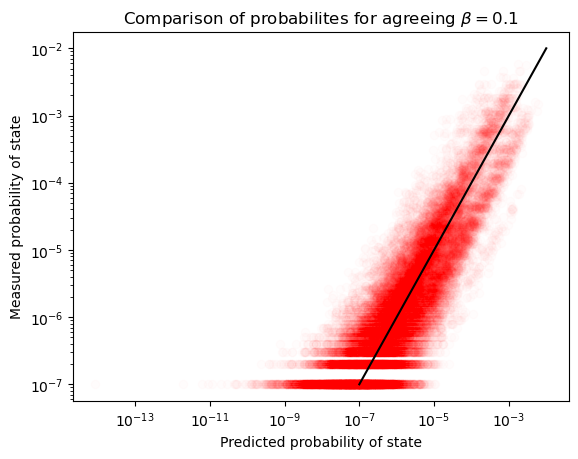

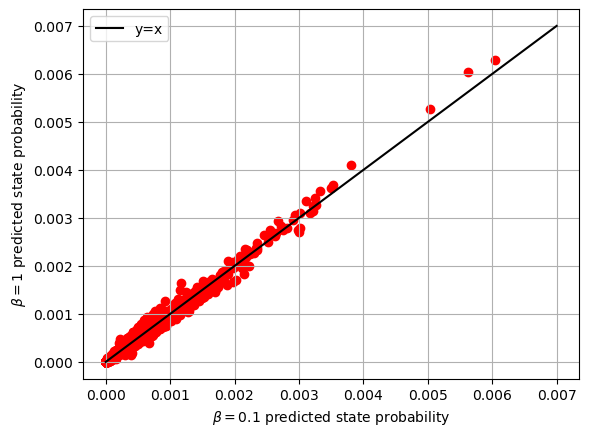

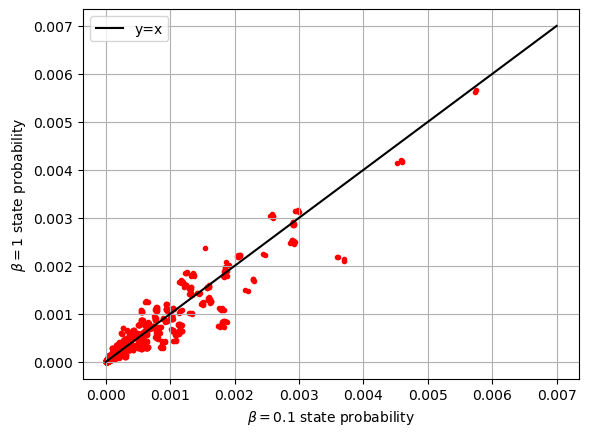

In [60]:
import matplotlib.pyplot as plt
plt.scatter(np.exp(prob2[:,0]), count[sorted_index1]/1e7, c='r',alpha=0.01)
# plt.scatter(np.exp(prob2[:,10]), count[sorted_index]/1e7, c='g',alpha=0.01,)
# plt.scatter(np.exp(prob2[:,20]), count[sorted_index]/1e7, c='b', alpha=0.01)
plt.plot([1e-7, 1e-2],[1e-7,1e-2], c='k')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Predicted probability of state")
plt.ylabel("Measured probability of state")
plt.title(r"Comparison of probabilites for agreeing $\beta=0.1$")
plt.show()

plt.scatter(np.exp(prob2[:,0]), np.exp(prob2[:,1]), c='r')
plt.plot([1e-7, 7e-3],[1e-7,7e-3], c='k', label='y=x')
plt.xlabel(r"$\beta=0.1$ predicted state probability")
plt.ylabel(r"$\beta=1$ predicted state probability")
plt.legend()
plt.grid()
plt.show()

plt.scatter(count1/1e7, count2/1e7, c='r',marker='.')
plt.plot([1e-7, 7e-3],[1e-7,7e-3], c='k', label='y=x')
plt.xlabel(r"$\beta=0.1$ state probability")
plt.ylabel(r"$\beta=1$ state probability")
plt.legend()
plt.grid()

In [11]:
import torch
transformer.eval()
x = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
spins = torch.tensor([x]).T
print(spins.reshape((4,4)))
dataset_index = 0
print('beta',dataset.beta[dataset_index])
phys_params = torch.tensor([[dataset.beta[dataset_index]]])
p = transformer(spins, phys_params=phys_params)
print('output')
print(p.exp())
print('pred', torch.sum(p*torch.nn.functional.one_hot(spins, num_classes=2)).exp())
print('true', torch.sum(torch.all(torch.from_numpy(dataset.datasets[dataset_index][:]) == spins, axis=0))/1e6)

tensor([[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1]])
beta 0.1
output
tensor([[[0.5225, 0.4775]],

        [[0.9571, 0.0429]],

        [[0.5947, 0.4053]],

        [[0.4267, 0.5733]],

        [[0.9350, 0.0650]],

        [[0.6180, 0.3820]],

        [[0.7957, 0.2043]],

        [[0.4936, 0.5064]],

        [[0.6866, 0.3134]],

        [[0.7326, 0.2674]],

        [[0.7194, 0.2806]],

        [[0.6950, 0.3050]],

        [[0.4679, 0.5321]],

        [[0.4568, 0.5432]],

        [[0.7869, 0.2131]],

        [[0.6703, 0.3297]]], grad_fn=<ExpBackward0>)
pred tensor(0.0004, grad_fn=<ExpBackward0>)
true tensor(0.0027)


In [9]:
import torch
import numpy as np

from transformer_model import compute_energy, int_to_binary
from dataloader import QCTempDataset

delta = 1.1
rb = 1.2
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp",
                        size=(4,4), Rb_per_a=rb, delta_per_omega=delta, lattice='SquareLattice')  
natoms = 16
i = -1
f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)
val, bins = np.histogram(f(dataset.datasets[i][:].T), bins=np.arange(2**natoms+1))
logp = torch.from_numpy(np.log(val/np.sum(val)))
total_configs = int_to_binary(torch.arange(2**natoms), natoms)
print(compute_energy(total_configs, logp, {'omega':25.132741228718345, 'delta_per_omega':1.1, 'rb_per_a':1.2},atoms=natoms))
print(dataset.beta[i])
print(dataset.energy[i], dataset.energy_error[i])


c=5420441.132650757 omega=25.132741228718345 rb=7.744008044106029 a=6.453340036755025 delta=27.646015351590183
tensor([ -0.0000, -27.6460, -27.6460, -55.2920, -27.6460, -55.2920, -55.2920,
        -82.9380, -27.6460, -55.2920])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5046e+01, 0.0000e+00, 1.1726e+00,
        7.5046e+01, 1.5126e+02, 0.0000e+00, 1.0294e-01])
tensor(-134.8187, dtype=torch.float64)
-224.53449623260047
9.578947368421051
-224.92359533705573 0.01521405390797183


/home/jkambulo/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
